Here we set the model to run using CPU. By doing this we can inspect the model using the CPU while we train another using the GPU.

In [26]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [27]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from PIL import Image
from functools import reduce
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE

In [28]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [29]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.1)

In [30]:
train_dir = './data/FlagsMashupBot/autoencoder_images/train/0/'
train_files = [f for f in os.listdir(train_dir) if not f.startswith('.')]
val_dir = './data/FlagsMashupBot/autoencoder_images/val/0/'
val_files = [f for f in os.listdir(val_dir) if not f.startswith('.')]
# test_dir = './data/FlagsMashupBot/autoencoder_images/test/0/'
# test_files = [f for f in os.listdir(test_dir) if not f.startswith('.')]

In [31]:
len(train_files), len(val_files)#, len(test_files)

(5014, 1101)

### Load model

In [61]:
autoencoder = tf.keras.models.load_model('./256_model_6000.hdf5')

In [62]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 8)         0     

#### latent model

In [63]:
# input_img = autoencoder.get_layer('input_2').output
# encoded = autoencoder.get_layer('max_pooling2d_10').output
input_img = autoencoder.get_layer('input_1').output
encoded = autoencoder.get_layer('max_pooling2d_2').output
latent_model = Model(input_img, encoded)

In [64]:
input_img.shape

TensorShape([None, 256, 256, 3])

In [65]:
_, IMG_HEIGHT, IMG_WIDTH, _ = input_img.shape
IMG_HEIGHT, IMG_WIDTH

(256, 256)

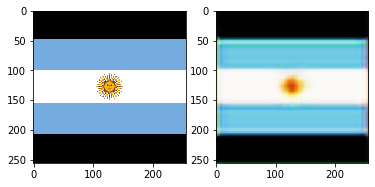

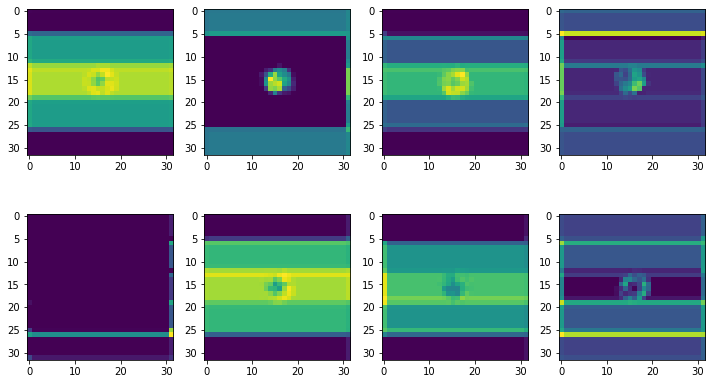

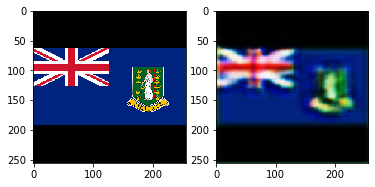

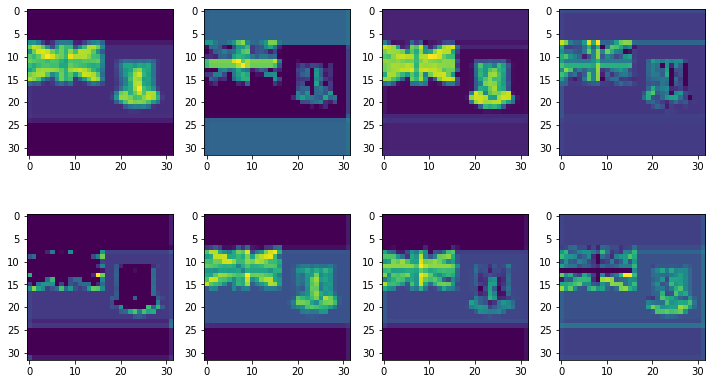

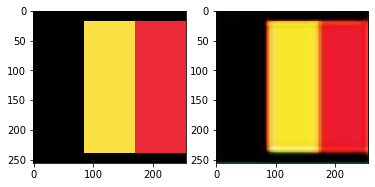

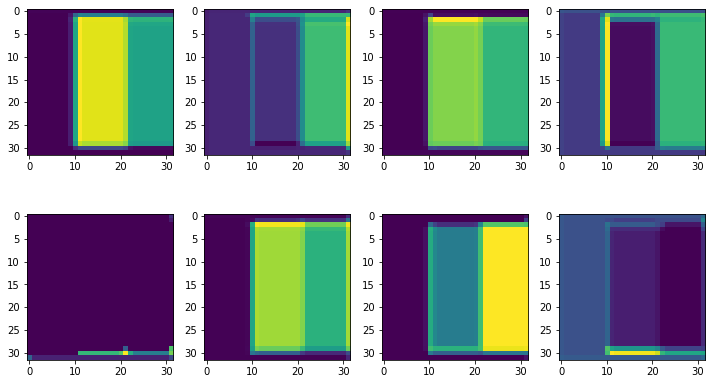

In [66]:
def plot_latents(input_image):
    test_im = Image.open(input_image).convert('RGB')
    test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
    test_ar = np.asarray(test_im) / 255
    test_ar = np.expand_dims(test_ar,0)
    
    pred = autoencoder.predict(test_ar)
    
    for real, coded in zip(test_ar, pred):
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(real)
        plt.subplot(1,2,2)
        plt.imshow(coded)   
    
    coded_image = latent_model.predict(test_ar)
    coded_dims = coded_image.shape[-1]

    plt.figure(figsize = (10,6))
    for i in range(coded_dims):
        plt.subplot(int(np.ceil(coded_dims)/4),4, i+1)
        plt.imshow(coded_image[0, :, :, i])
    plt.tight_layout()    
    
    return pred, coded_image

_ ,_ = plot_latents('./data/FlagsMashupBot/reals_square_png/arg.png')
_ ,_ = plot_latents('./data/FlagsMashupBot/reals_square_png/vgb.png')
_ ,_ = plot_latents('./data/FlagsMashupBot/reals_square_png/bel.png')

### Latent space representation
https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points

In [67]:
info = requests.get('https://restcountries.eu/rest/v2/all')
info = pd.DataFrame(info.json())

In [68]:
info[info.name == 'Belgium']

,name,topLevelDomain,alpha2Code,alpha3Code,callingCodes,capital,altSpellings,region,subregion,population,...,timezones,borders,nativeName,numericCode,currencies,languages,translations,flag,regionalBlocs,cioc
21,Belgium,[.be],BE,BEL,[32],Brussels,"[BE, België, Belgie, Belgien, Belgique, Kingdo...",Europe,Western Europe,11319511,...,[UTC+01:00],"[FRA, DEU, LUX, NLD]",België,056,"[{'code': 'EUR', 'name': 'Euro', 'symbol': '€'}]","[{'iso639_1': 'nl', 'iso639_2': 'nld', 'name':...","{'de': 'Belgien', 'es': 'Bélgica', 'fr': 'Belg...",https://restcountries.eu/data/bel.svg,"[{'acronym': 'EU', 'name': 'European Union', '...",BEL


In [69]:
latent_path = './data/FlagsMashupBot/reals_square_png/'
latent_files = [f for f in os.listdir(latent_path) if f.endswith('.png')]

Generate DataFrame with country name, latent representation, real representation

In [70]:
latent_flags = pd.DataFrame()
for f in latent_files:
    test_im = Image.open(latent_path + f).convert('RGB')
    test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
    test_ar = np.asarray(test_im) / 255
    test_ar_exp = np.expand_dims(test_ar,0)

    latent_pred = latent_model.predict(test_ar_exp)
    code = f.split('.')[0].upper()
    country_info = info[info.alpha3Code == code].iloc[0]
    one = {
        'code': code, 
        'name': country_info.name, 
        'file': f, 
        '3d_latent': np.squeeze(latent_pred[0, :, :, :]),
        '1d_latent': np.ravel(np.squeeze(latent_pred[0, :, :, :])),
        '3d_real': test_ar}
    country_df = pd.DataFrame([one], index = [0])
    latent_flags = latent_flags.append(country_df, ignore_index=True)

Real TSNE

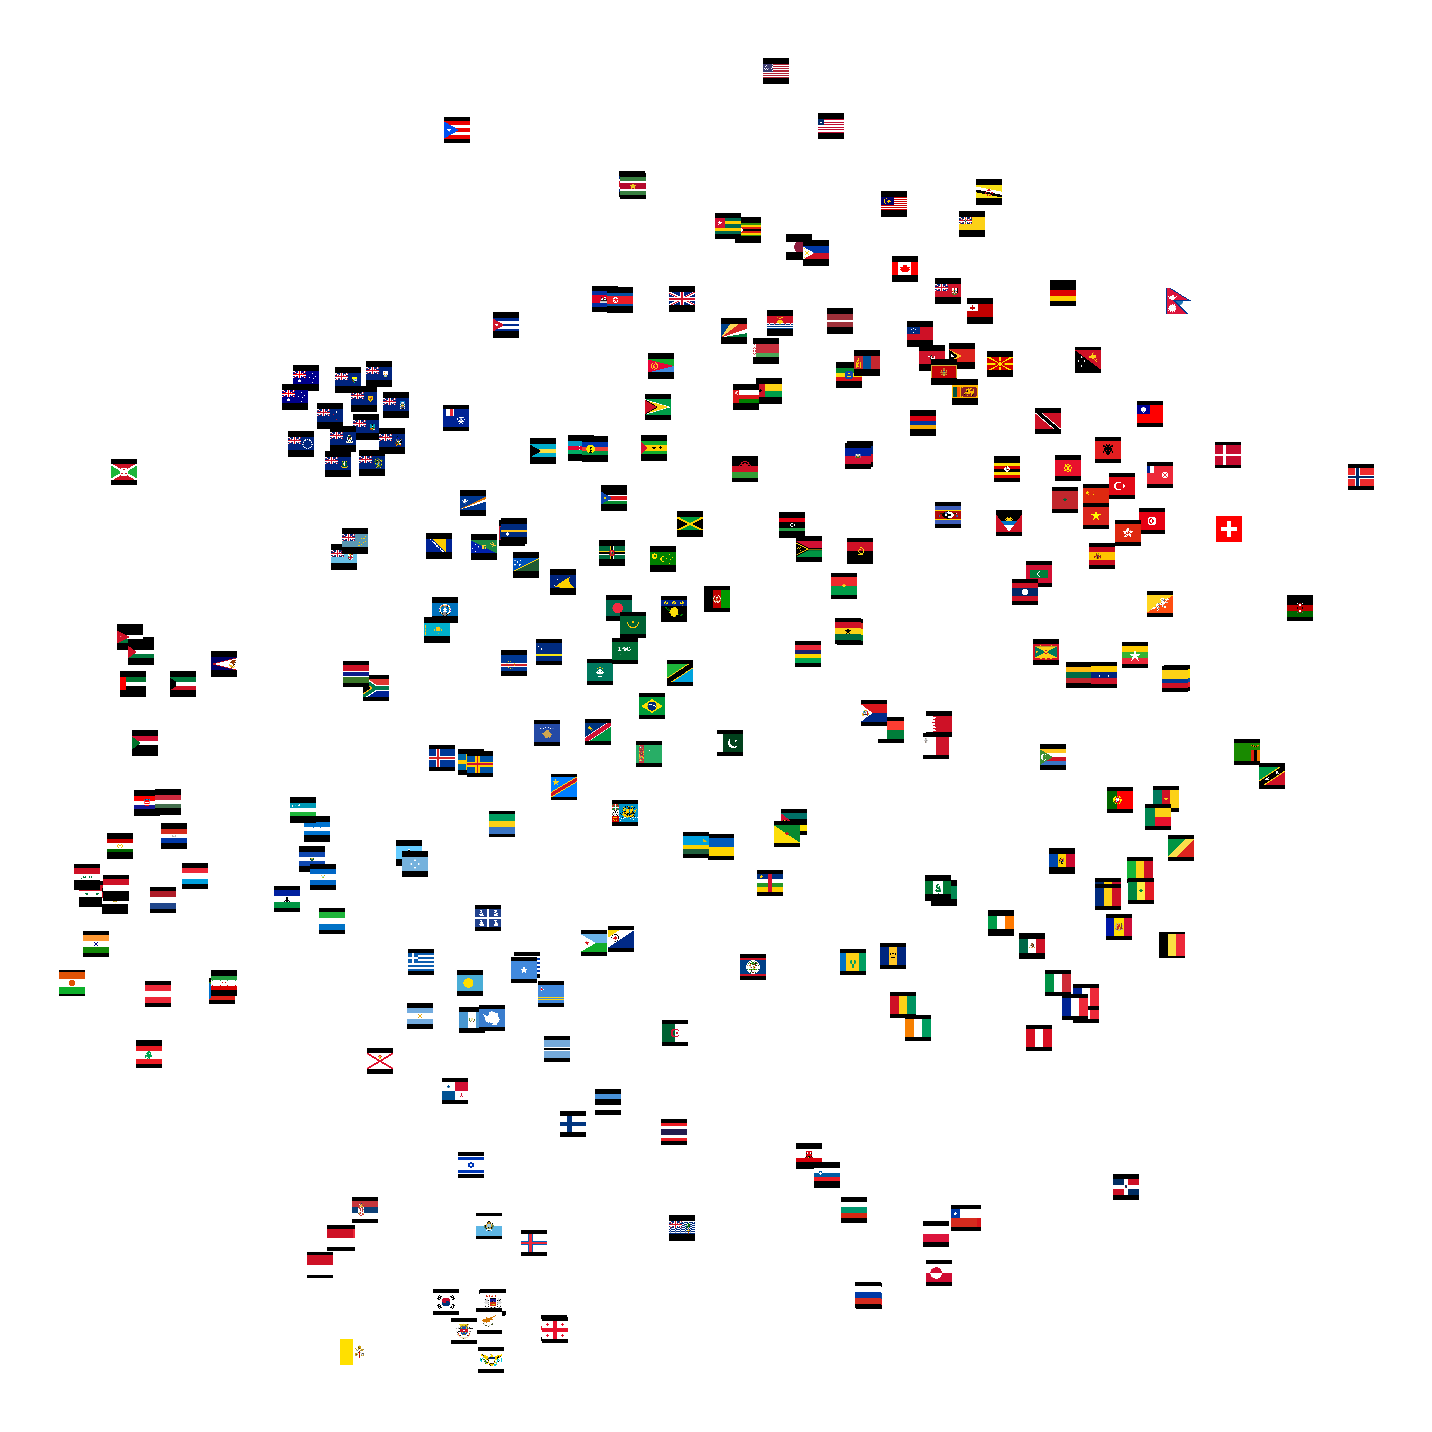

In [71]:
real_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(np.vstack([np.ravel(val3d) for val3d in latent_flags['3d_real'].values]))

plt.figure(figsize=(20, 20))
ax = plt.subplot(1,1,1)
plt.scatter(real_tsne[:, 0], real_tsne[:, 1])
for x0, y0, file in zip(real_tsne[:, 0], real_tsne[:, 1], latent_files):
    path = latent_path + file
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
# ax.set_facecolor('xkcd:black')
plt.axis('off')
plt.tight_layout()
plt.savefig('./tsne_real.png')

Latent TSNE

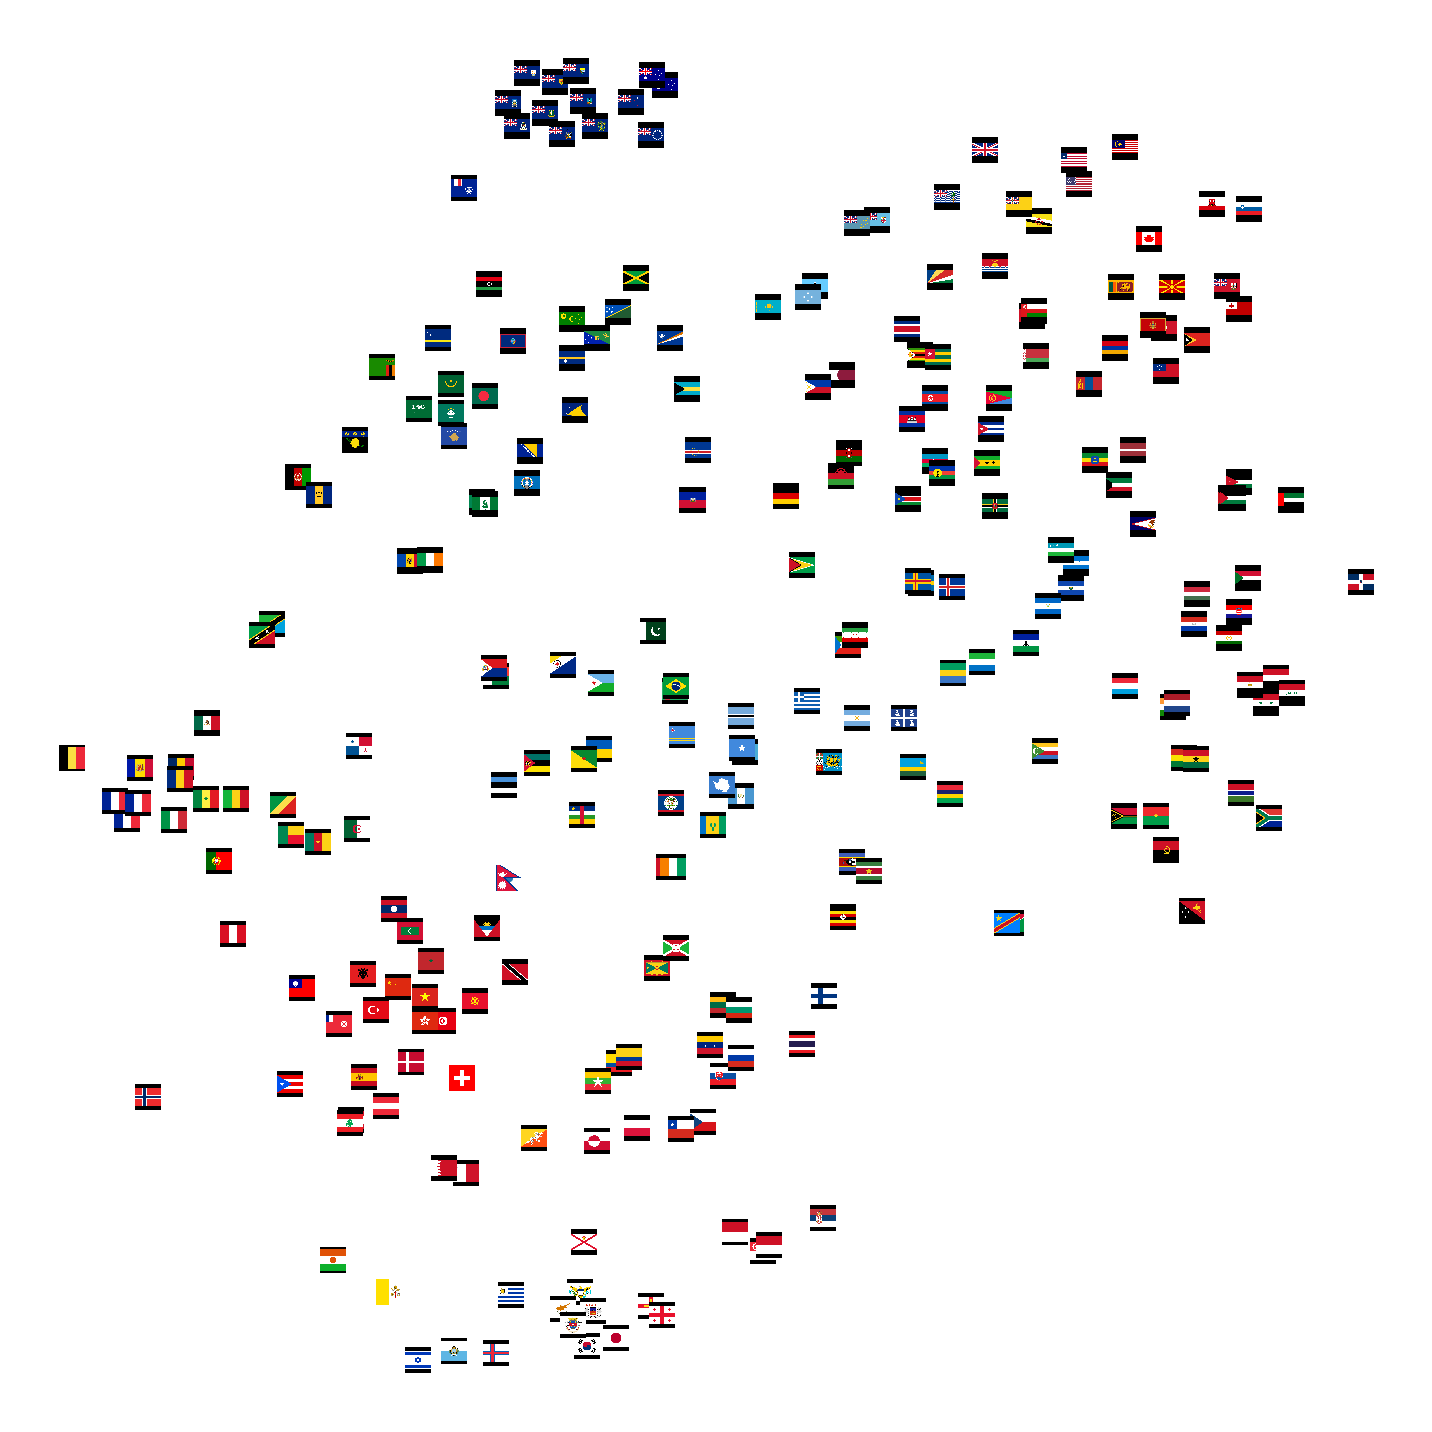

In [72]:
latent_tsne = TSNE(n_components=2, random_state=2).fit_transform(np.vstack(latent_flags['1d_latent'].values))
plt.figure(figsize=(20, 20))
ax = plt.subplot(1,1,1)
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1])
for x0, y0, file in zip(latent_tsne[:, 0], latent_tsne[:, 1], latent_files):
    path = latent_path + file
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.axis('off')
plt.tight_layout()
plt.savefig('./tsne_latent_6000.png')
    